# Analysis of Scarman house data

In [53]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import calendar
from pandas.tseries import offsets
import os
from datetime import date
import holidays

%matplotlib inline  

blues = [x for x in reversed(sns.color_palette("Blues_d", 11))]

uk_hol= holidays.UK() #load UK holiday

import sys
sys.path.append("/Users/macintosh/Documents/OneDrive - Cardiff University/05 - Python/01 - Packages")
import Classes.regression as regression

#http://www2.warwick.ac.uk/services/centraltimetabling/help/academicweeks/?acYear=201516

In [54]:
path = r'/Users/macintosh/Documents/OneDrive - Cardiff University/04 - Projects/02 - Warwick/04 - Data/'
files = ["ScarmanHouse_ElecEnergykWh.csv", "ScarmanHouse_HeatEnergykWh.csv", "ScarmanHouse_HeatFlowm3.csv"]
drivers = "Coventry OAT 2016 - origin.xls"

## Cleaning and preparing dataset

In [55]:
def cleanAndPrepare(data, meterName):
    data["Date"]=data["Date"] + " " +data["StartTime"]
    data["Date"] = pd.to_datetime(data["Date"], format="%d/%m/%Y %H:%M")
    data.set_index("Date", drop=True, inplace=True)
    data.drop(["Meter", "Name", "SerialNumber", "Register", "StartTime", "Duration", "TotalValue", "Unit"], axis=1, inplace=True)
    data.columns = [meterName]

In [56]:
frames = []

for filename in files:
    data = pd.read_csv(path+filename)
    meterName = filename.split(".csv")[0]
    cleanAndPrepare(data, meterName)
    print(filename + " has " + '{:d}'.format(data[meterName].isnull().sum()) + " missing data")
    frames.append(data)
    
result = pd.concat(frames,axis=1)
result.set_index(pd.date_range(start=result.index[0], end=result.index[-1], freq='30T' ), inplace=True)
result.head()

ScarmanHouse_ElecEnergykWh.csv has 0 missing data
ScarmanHouse_HeatEnergykWh.csv has 0 missing data
ScarmanHouse_HeatFlowm3.csv has 0 missing data


,ScarmanHouse_ElecEnergykWh,ScarmanHouse_HeatEnergykWh,ScarmanHouse_HeatFlowm3
2016-01-01 00:00:00,26.0,0.1,3.3
2016-01-01 00:30:00,27.0,0.2,3.2
2016-01-01 01:00:00,29.0,0.1,3.3
2016-01-01 01:30:00,29.0,0.1,3.2
2016-01-01 02:00:00,29.0,0.2,3.3


## Add temperature data to the dataset

In [57]:
temperature = pd.read_excel(path+drivers)
temperature.head()
temperature.fillna(method="ffill", inplace=True) #Fill gaps in data with previous

temperature[temperature.columns[0]] = pd.to_datetime(temperature[temperature.columns[0]], format="%Y-%m-%d %H:%M:%S")
temperature.head()
temperature.set_index(temperature.columns[0], drop=True, inplace=True)

temperature = temperature.resample('30T').mean()
temperature = temperature.interpolate('time')
temperature.fillna(method="ffill", inplace=True)
result = result.join(temperature)

## Verifiy integrity of the dataset

In [58]:
numberOfValues = 365*48
if not result.index.year[0]%4:
    numberOfValues = 366*48
print("datatset is " + '{0:.2f}%'.format(result.shape[0]/numberOfValues*100) + " complete")

datatset is 100.00% complete


In [59]:
result.columns = ["Electricity", "Heat", "HeatFlow", "Temperature"]
result.head()

,Electricity,Heat,HeatFlow,Temperature
2016-01-01 00:00:00,26.0,0.1,3.3,2.7300
2016-01-01 00:30:00,27.0,0.2,3.2,2.6400
2016-01-01 01:00:00,29.0,0.1,3.3,2.5500
2016-01-01 01:30:00,29.0,0.1,3.2,1.5425
2016-01-01 02:00:00,29.0,0.2,3.3,0.5350


In [60]:
result["Hour"] = result.index.hour
result["DayOfWeek_name"]= [calendar.day_name[x] for x in result.index.dayofweek]
result["DayOfWeek"]= result.index.dayofweek
result["Month"] = result.index.month
result["Weekday"] = [1 if x<5 else 0 for x in result.index.dayofweek]
result["HH"] = [x%48 for x in range(0, result.shape[0], 1) ]
result["Holiday"]= [1 if x.date() in uk_hol else 0 for x in result.index]
result["Date"] = result.index.date

def get_season(row):
    if row['Month'] >= 3 and row['Month'] <= 5:
        return 'Spring'
    elif row['Month'] >= 6 and row['Month'] <= 8:
        return 'Summer'
    elif row['Month'] >= 9 and row['Month'] <= 11:
        return 'Autumn'
    else:
        return 'Winter'

result['Season'] = result.apply(get_season, axis=1)
result.head()

,Electricity,Heat,HeatFlow,Temperature,Hour,DayOfWeek_name,DayOfWeek,Month,Weekday,HH,Holiday,Date,Season
2016-01-01 00:00:00,26.0,0.1,3.3,2.7300,0,Friday,4,1,1,0,1,2016-01-01,Winter
2016-01-01 00:30:00,27.0,0.2,3.2,2.6400,0,Friday,4,1,1,1,1,2016-01-01,Winter
2016-01-01 01:00:00,29.0,0.1,3.3,2.5500,1,Friday,4,1,1,2,1,2016-01-01,Winter
2016-01-01 01:30:00,29.0,0.1,3.2,1.5425,1,Friday,4,1,1,3,1,2016-01-01,Winter
2016-01-01 02:00:00,29.0,0.2,3.3,0.5350,2,Friday,4,1,1,4,1,2016-01-01,Winter


# Electricity

## Annual consumption

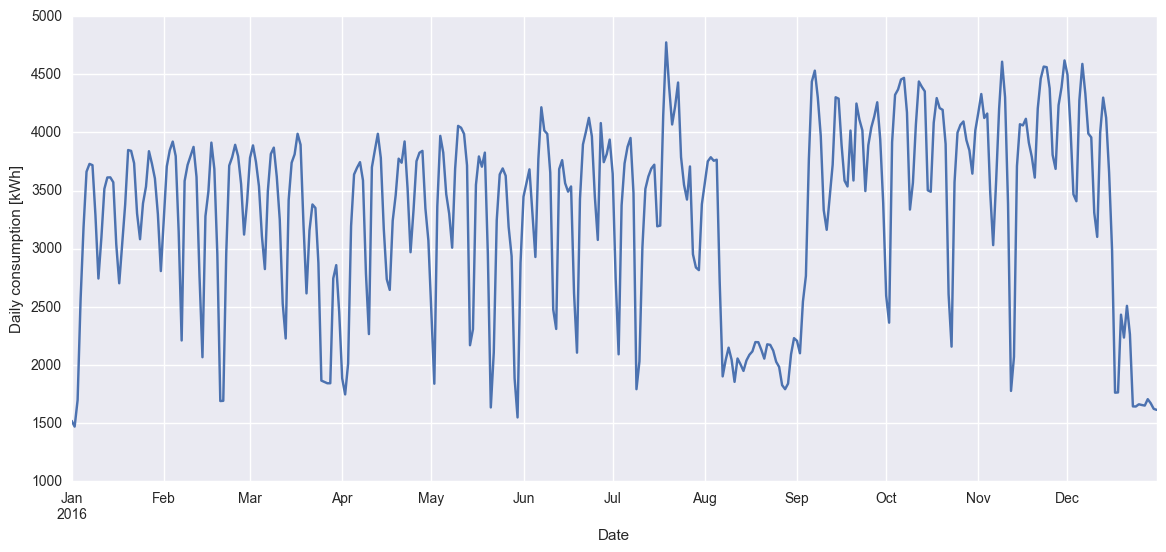

In [61]:
fig, ax = plt.subplots(figsize=(14, 6))
result["Electricity"].resample('d').sum().plot(ax=fig.gca())
ax.set_xlabel("Date")
ax.set_ylabel("Daily consumption [kWh]")

## Correlation between temperature and electricity (HH resolution)

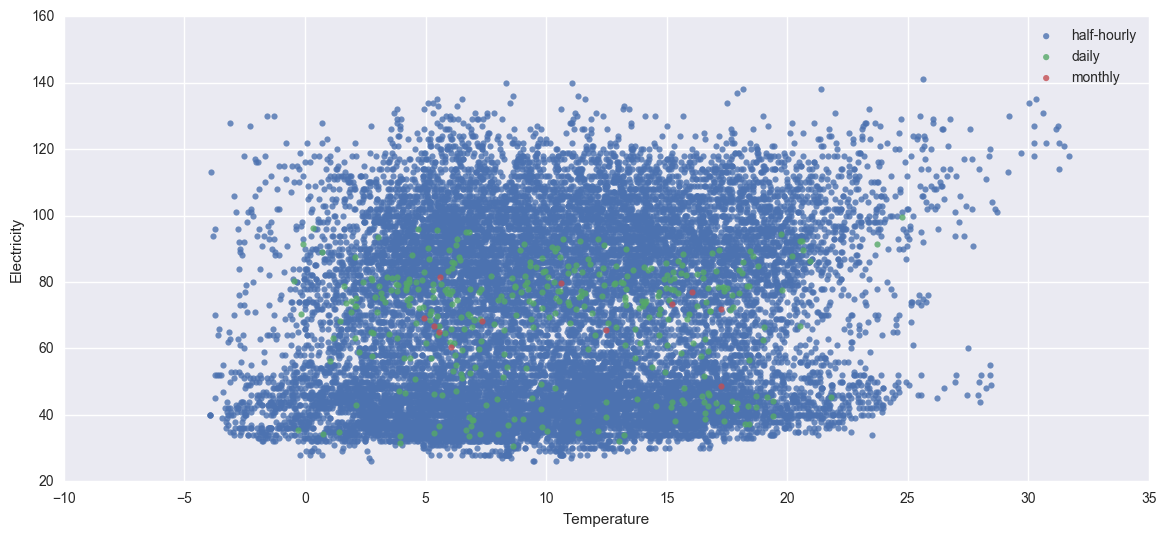

In [62]:
x_data = "Temperature"
y_data = "Electricity"
fig, ax = plt.subplots(figsize=(14, 6))
sns.regplot(x=x_data, y=y_data, data=result, fit_reg=False, ax=ax, label="half-hourly")
sns.regplot(x=x_data, y=y_data, data=result.resample("d").mean(), fit_reg=False, ax=ax, label="daily")
sns.regplot(x=x_data, y=y_data, data=result.resample("m").mean(), fit_reg=False, ax=ax, label="monthly")
legend = plt.legend()

## HH consumption for the average week by season 

In [63]:
averageWeekbyHH = result.groupby(["DayOfWeek_name", "HH", "Season"]).mean().reset_index()
averageWeekbyHH["index"]= averageWeekbyHH["DayOfWeek"] + averageWeekbyHH["HH"]/100#averageWeekbyHH["DayOfWeek"].map(str) + " " + averageWeekbyHH["HH"].map(str)
averageWeekbyHH.set_index(["index", "Season"], inplace=True)
averageWeekbyHH.sort_values(["DayOfWeek", "HH"], inplace=True)
df = averageWeekbyHH.unstack("Season")
df.set_index(df["DayOfWeek_name", "Autumn"], inplace=True)

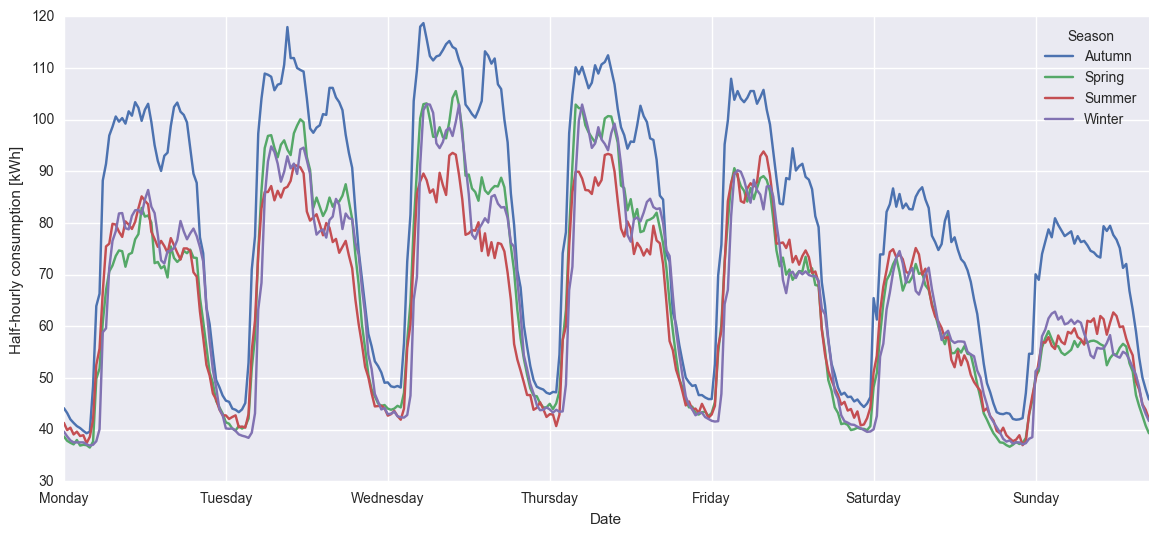

In [64]:
fig, ax = plt.subplots(figsize=(14, 6))
df["Electricity"].plot(ax=fig.gca())
ax.set_xlabel("Date")
ax.set_ylabel("Half-hourly consumption [kWh]")

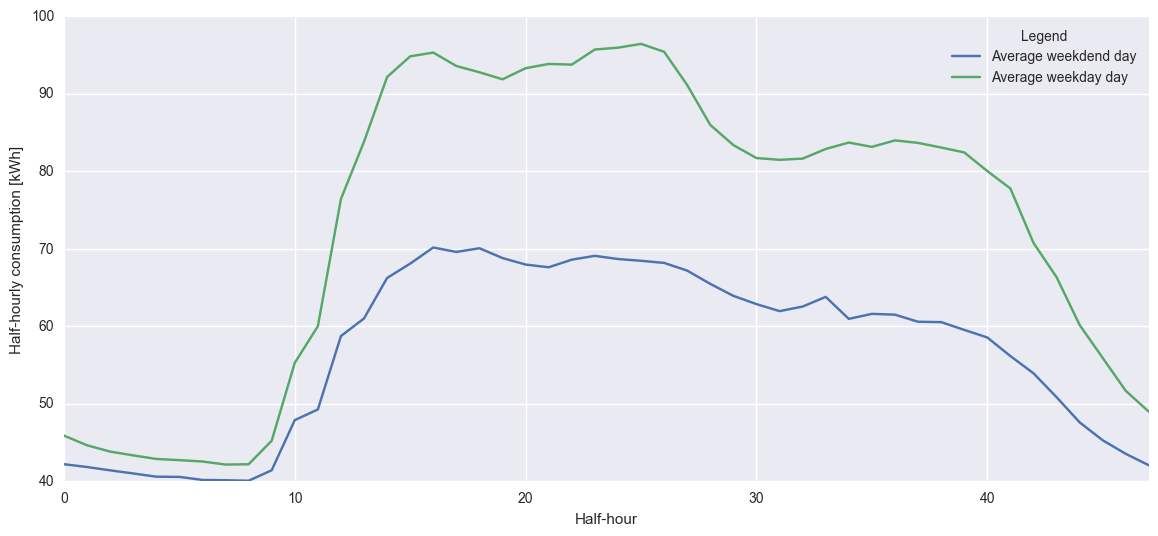

In [65]:
averageDaybyHH = result.groupby(["Weekday", "HH"]).mean()
fig, ax = plt.subplots(figsize=(14, 6))
averageDaybyHH.unstack("Weekday")["Electricity"].plot(ax=fig.gca())
lines, labels = ax.get_legend_handles_labels()
labels = ["Average weekdend day", "Average weekday day"]
ax.legend(lines, labels, title="Legend")
ax.set_xlabel("Half-hour")
ax.set_ylabel("Half-hourly consumption [kWh]")

# Heat and Heat flow

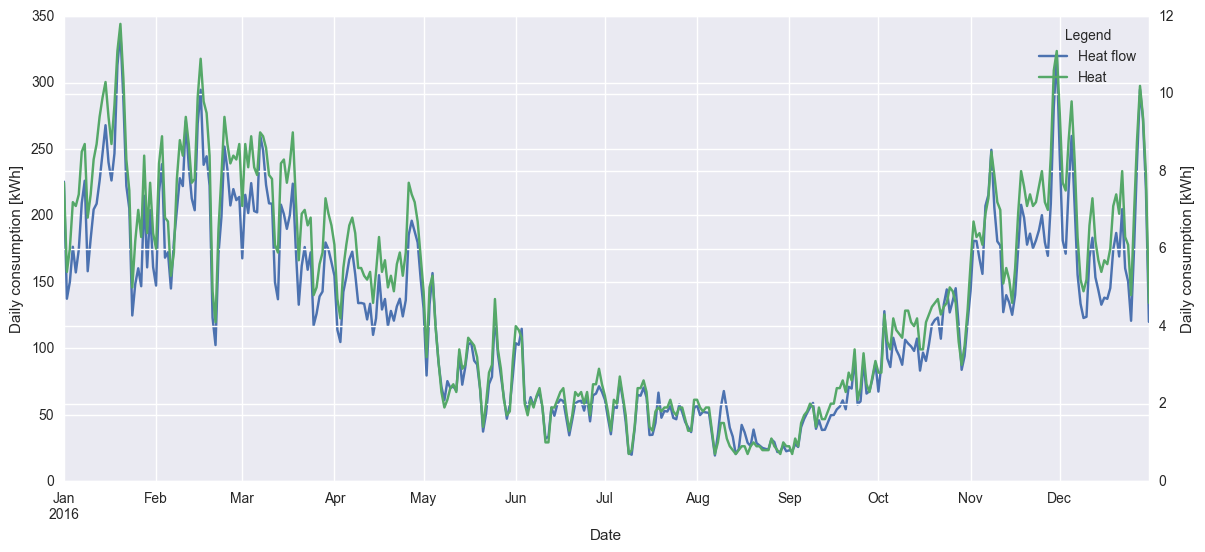

In [66]:
fig, ax = plt.subplots(figsize=(14, 6))
# result["Heat"].resample('d').sum().plot(ax=fig.gca())
result["HeatFlow"].resample('d').sum().plot(ax=ax, label="Heat flow")
ax2 =ax.twinx()
result["Heat"].resample('d').sum().plot(ax=ax2, color=sns.color_palette()[1], label="Heat")
ax.set_xlabel("Date")
ax.set_ylabel("Daily consumption [kWh]")
ax2.set_ylabel("Daily consumption [kWh]")

lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
lines= lines+lines2
labels=labels+labels2
ax.legend(lines, labels, title="Legend")

## As seen in the graph above, the linear relation between Heat and Heat flow can be observed again in the graph below.

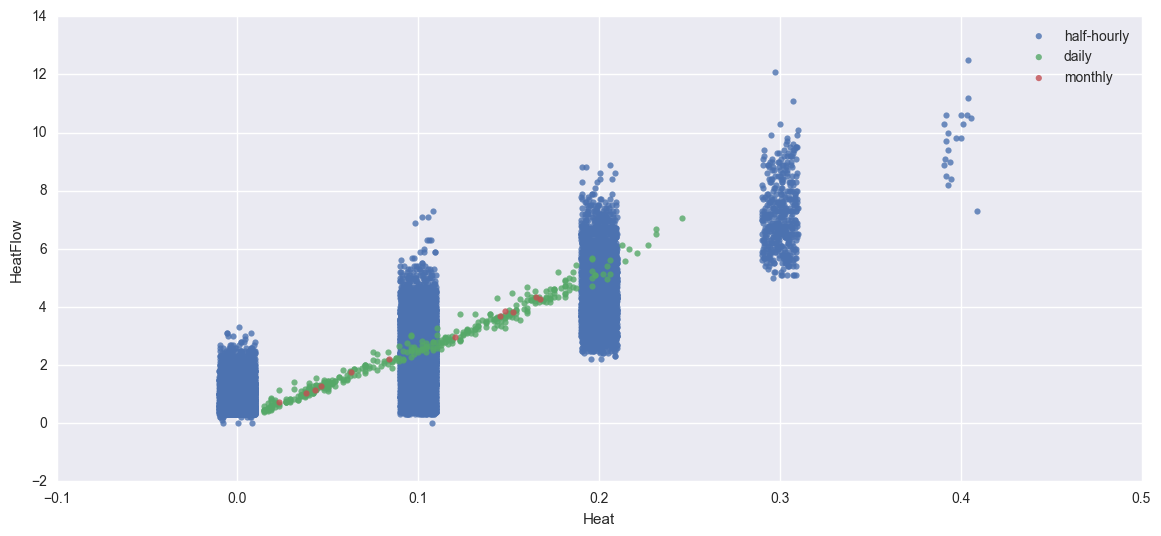

In [67]:
x_data = "Heat"
y_data = "HeatFlow"
fig, ax = plt.subplots(figsize=(14, 6))
sns.regplot(x=x_data, y=y_data, data=result, fit_reg=False, ax=ax, label="half-hourly", x_jitter=0.01)
sns.regplot(x=x_data, y=y_data, data=result.resample("d").mean(), fit_reg=False, ax=ax, label="daily")
sns.regplot(x=x_data, y=y_data, data=result.resample("m").mean(), fit_reg=False, ax=ax, label="monthly")
legend = plt.legend()

# Heat

## Relation between Heat and Temperature 

We can observe that the relation between heat and temperature at half hourly resolution is not obvious. Although at daily and monthly resolution, the relation becomes obvious and we can observe a linear relation between the two when temperature is below ~15C and a flat line when above. This difference can be explained by the delay in reaction of the system to the outdoor temperature. 
More details can be found about shift-error and change point model here: http://www.ibpsa.us/sites/default/files/publications/SB10-PPT-IS09C-02-Kissock.pdf

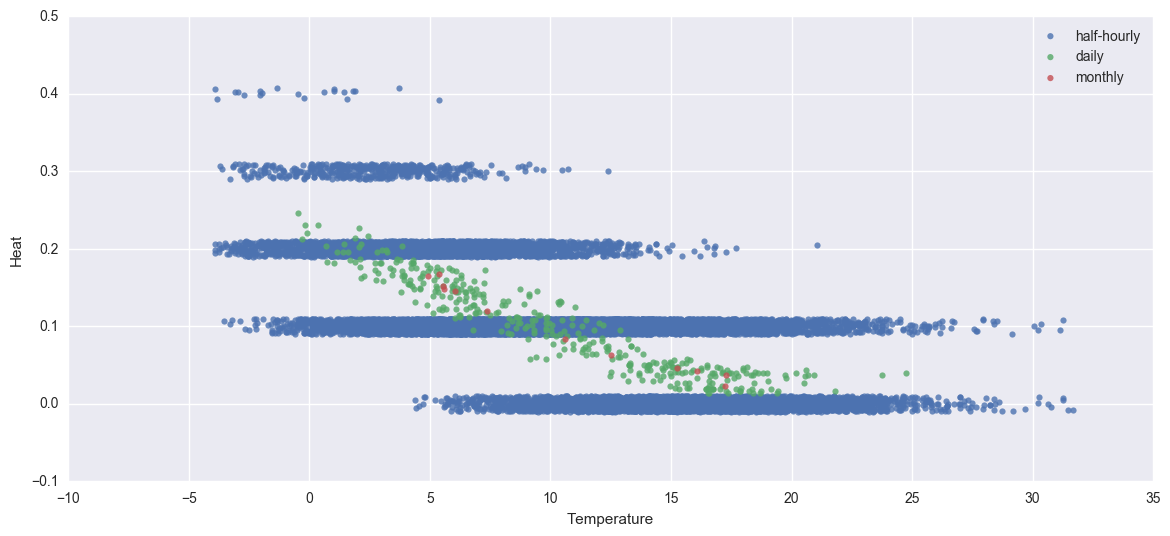

In [68]:
x_data = "Temperature"
y_data = "Heat"
fig, ax = plt.subplots(figsize=(14, 6))
sns.regplot(x=x_data, y=y_data, data=result, fit_reg=False, ax=ax, label="half-hourly", y_jitter=0.01)
sns.regplot(x=x_data, y=y_data, data=result.resample("d").mean(), fit_reg=False, ax=ax, label="daily")
sns.regplot(x=x_data, y=y_data, data=result.resample("m").mean(), fit_reg=False, ax=ax, label="monthly")
legend = plt.legend()

Regression
equation: Y= 1.414362-0.549875*X*(T-16.688995 )


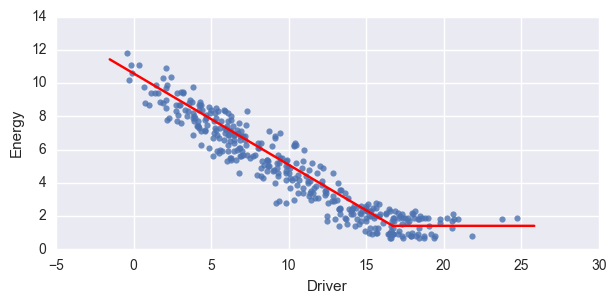

In [69]:
daily_data = result.resample("d").agg({"Heat": np.sum, "Temperature":np.mean})
model = regression.Regression()
model._model(daily_data.copy(), verbose_eval=False)
model._plot()
params= model.param

## Using the equation calculated previously, we can estimate breakdown the consumption between space heating consumption and hot water consumption

In [70]:
daily_data["Space heating"]= [params[1]*(temp-params[2]) if temp<params[2] else 0 for temp in daily_data["Temperature"]]
daily_data["Hot water"] = daily_data["Heat"] - daily_data["Space heating"]
daily_data.loc[daily_data["Hot water"]<0, :]=0
daily_data.head()

,Heat,Temperature,Space heating,Hot water
2016-01-01,7.7,3.924167,7.019064,0.680936
2016-01-02,5.4,8.621354,4.436197,0.963803
2016-01-03,6.0,6.668958,5.509771,0.490229
2016-01-04,7.2,6.145417,5.797654,1.402346
2016-01-05,7.1,6.905208,5.379863,1.720137


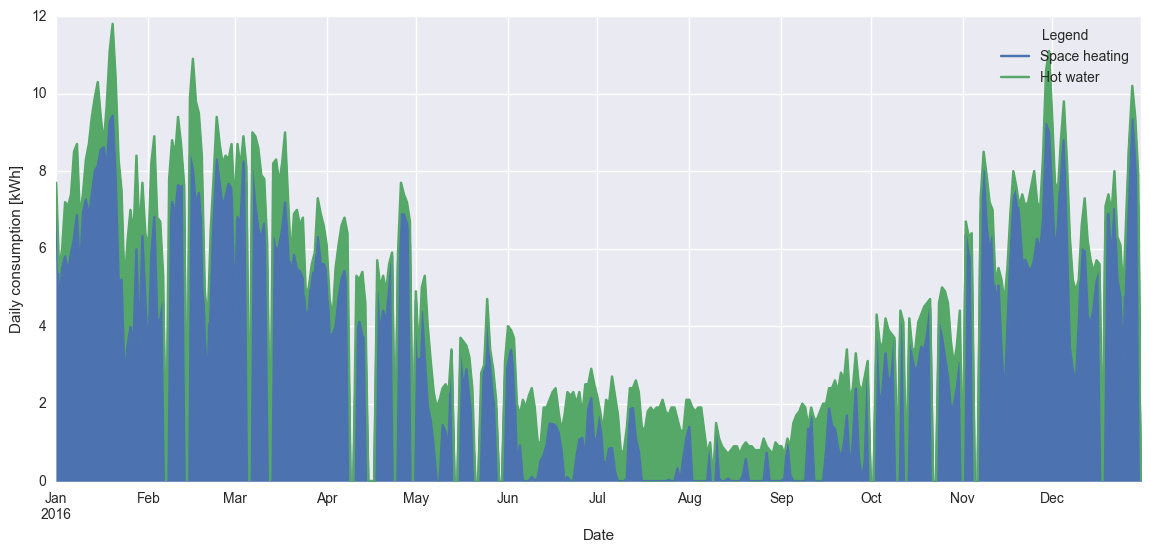

In [75]:
fig, ax = plt.subplots(figsize=(14, 6))
daily_data[["Space heating", "Hot water"]].plot.area(ax=ax, stacked=True)
ax.set_xlabel("Date")
ax.set_ylabel("Daily consumption [kWh]")
ax.legend(title="Legend")